In [1]:
!pip install -q --upgrade pip
!pip install -q cleanlab

In [2]:
from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import ParameterGrid
import numpy as np
from cleanlab.classification import LearningWithNoisyLabels
from cleanlab.noise_generation import generate_noisy_labels
from cleanlab.util import value_counts
from cleanlab.latent_algebra import compute_inv_noise_matrix
# visualize
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%config InlineBackend.figure_formats = {'png', 'retina'}

seed = 2

### 簡素なチュートリアル
https://github.com/cgnorthcutt/cleanlab/blob/master/examples/iris_simple_example.ipynb より

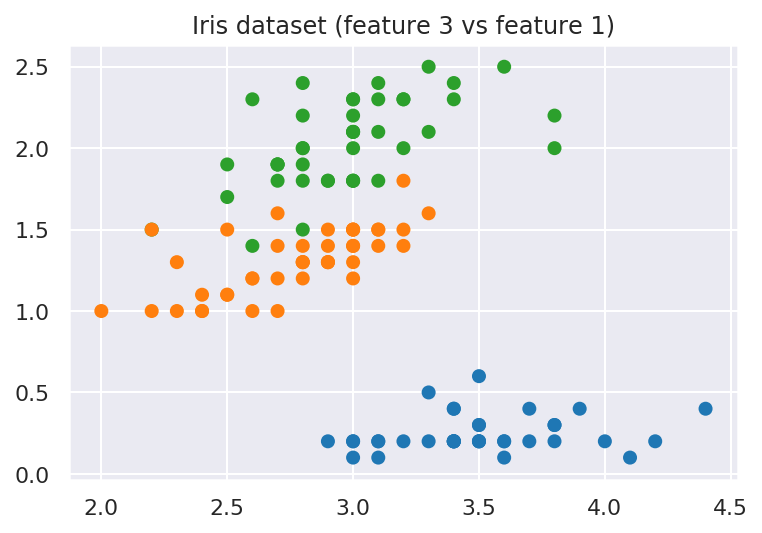

In [3]:
# irisをロード&可視化
iris = datasets.load_iris()
X = iris.data  # we only take the first two features.
y = iris.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=seed)
colorlist=plt.cm.tab10([0,1,2])
plt.scatter(X_train[:,1],X_train[:,3],c=[colorlist[y] for y in y_train])
plt.title("Iris dataset (feature 3 vs feature 1)");

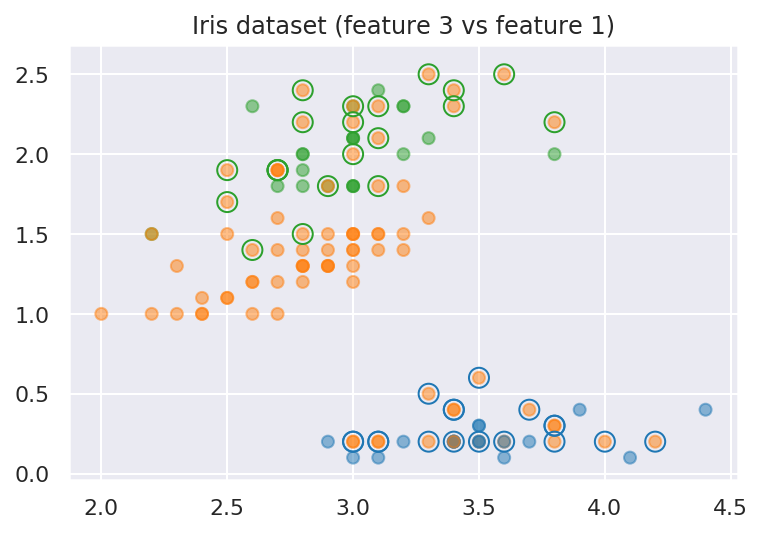

In [4]:
# noisy labelを生成
noise_matrix = np.array([
    [0.5, 0.0, 0.0],
    [0.5, 1.0, 0.5],
    [0.0, 0.0, 0.5],
]) #Q_{i|j}である. iはgiven label, jはtrue labelでQはjで条件付けたiの分布

np.random.seed(seed=seed)
y_train_corrupted=generate_noisy_labels(y_train,noise_matrix) #noise_matrixからnoisy labelを生成(神か？)

y_is_corrupted= (y_train!=y_train_corrupted)

plt.scatter(X_train[:,1],X_train[:,3],c=[colorlist[y] for y in y_train_corrupted],alpha=0.5)
plt.scatter(X_train[y_is_corrupted,1],X_train[y_is_corrupted,3],
            s=100, facecolors='none', edgecolors=[colorlist[y] for y in y_train[y_is_corrupted]])
plt.title("Iris dataset (feature 3 vs feature 1)");

cleanlabは、`.fit(X, y, sample_weight), .predict(X), .predict_proba(X)`があればうまくラップしてくれる。

In [5]:
# modelの用意とcleanlabのクラスの用意
clf = LogisticRegression(solver='lbfgs', multi_class='auto', max_iter=1000, random_state=seed)
rp = LearningWithNoisyLabels(clf=clf, seed=seed) #defaltでは5cross-validしてくれる
# LearningWithNoisyLabelsの中を見てどのようなことを行っているのか理解しよう #サンプルを省いてる？それとも擬似ラベリングしてる？

In [6]:
# if clean label
clf.fit(X_train,y_train)
print('normal ML with clean label', clf.score(X_test,y_test))

normal ML with clean label 0.9666666666666667


In [7]:
# without confident learning
clf.fit(X_train,y_train_corrupted)
print('without confident learning', clf.score(X_test,y_test))

without confident learning 0.5


In [8]:
# with confident learning unknown joint
rp.fit(X_train,y_train_corrupted)
print('with confident learning unknown joint', rp.score(X_test, y_test))

with confident learning unknown joint 0.8


In [9]:
# 実はnoise matrixがわかっているときはもっといい推定ができる
rp.fit(X_train,y_train_corrupted, noise_matrix=noise_matrix) #p(i|j)
print('with confident learning given noise matrix', rp.score(X_test, y_test))

# 逆noise行列にも対応
py=value_counts(y_train) #py[j], クラスiに属するサンプルの個数 #これは真
inv=compute_inv_noise_matrix(py,noise_matrix)
rp.fit(X_train,y_train_corrupted, noise_matrix=noise_matrix, inverse_noise_matrix=inv) #p(i|j)
print('with confident learning given noise matrix and inverse noise matrix', rp.score(X_test, y_test))

with confident learning given noise matrix 0.8666666666666667
with confident learning given noise matrix and inverse noise matrix 0.8666666666666667


パラメーターチューニングは省略 ∵現実で真のyはわからないから